In [179]:
# import stuff here
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

In [6]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

def list_data(folder):
    """
    List all available data sets in the folder
    
    """
    s3 = boto3.resource('s3')
    bucket='cp-hackathon-data'
    hackathon_data = s3.Bucket(bucket)
    keys = []
    for obj in hackathon_data.objects.filter(Prefix=folder):
        keys.append(obj.key)
    return keys
def get_data(key):
    role = get_execution_role()
    bucket='cp-hackathon-data'
    data_location = 's3://{}/{}'.format(bucket, key)
    return pd.read_csv(data_location)

In [7]:
list_data('RedCross')

['RedCross/',
 'RedCross/ovitrap_data.csv',
 'RedCross/ovitrap_data_monthly_province.csv',
 'RedCross/weather_data_monthly_province.csv']

In [8]:
mosq = get_data('RedCross/ovitrap_data_monthly_province.csv').sort_values(['adm_level', 'date'])

Couldn't call 'get_role' to get Role ARN from role name cp-sagemaker-hackathon-role to get Role path.


In [11]:
mosq['date'] = pd.to_datetime(mosq.date).dt.date
mosq.loc[mosq.count_ovi>0].groupby('adm_level', as_index=False).sum().sort_values('count_ovi', ascending=False).head()

,adm_level,count_ovi,mean_ovi,error_ovi,error_relative_ovi
65,Pangasinan,9615.0,1384.900412,195.895837,8.466437
10,Batangas,6632.0,1160.544314,132.908643,7.757148
66,Quezon,6378.0,1104.754133,126.427465,4.009551
64,Pampanga,5146.0,464.914480,91.345518,6.637146
38,Iloilo,5032.0,1619.130424,161.384422,4.790436


In [12]:
df = mosq.loc[(mosq.adm_level == 'Pangasinan')&(mosq.count_ovi>0)].reset_index()
df.rename(mapper={'index':'old_index'}, axis=1, inplace=True)

In [13]:
df['next_month'] = df.old_index + 1
df['next_point'] = pd.concat([df.old_index[1:],pd.Series(df.old_index.iloc[-1] + 1)]).reset_index(drop=True)
df['consecutive'] = df.next_point - df.next_month

In [14]:
consecutive = df.iloc[1:43]

In [15]:
train = consecutive[['date', 'mean_ovi']]
test = df[43:53][['date', 'mean_ovi']]
train = pd.DataFrame(train, columns=['date','mean_ovi']).set_index('date')
test = pd.DataFrame(test, columns=['date','mean_ovi']).set_index('date')

In [16]:
train.sort_index().tail(2)

,mean_ovi
date,
2016-03-01,16.635726
2016-04-01,29.410000


In [17]:
test.sort_index().head(3)

,mean_ovi
date,
2016-06-01,38.737222
2016-07-01,37.109107
2016-08-01,35.852651


In [18]:
empty=pd.DataFrame()
empty['date'] = pd.Series(['2016-05-01'])
empty['date'] = pd.to_datetime(empty['date']).dt.date
empty['mean_ovi'] = np.nan
empty = pd.DataFrame(empty, columns=['date','mean_ovi']).set_index('date')

In [19]:
empty

,mean_ovi
date,
2016-05-01,NaN


In [20]:
result = adfuller(train.mean_ovi)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.345824
p-value: 0.000370
Critical Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607


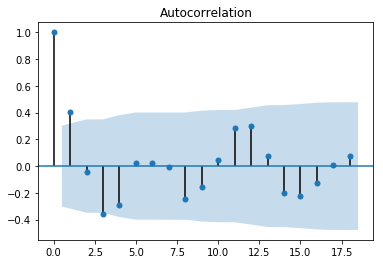

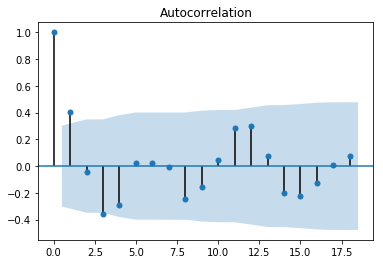

In [21]:
plot_acf(train.mean_ovi, lags=18)

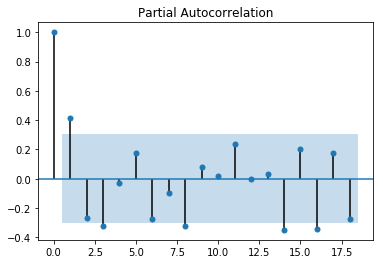

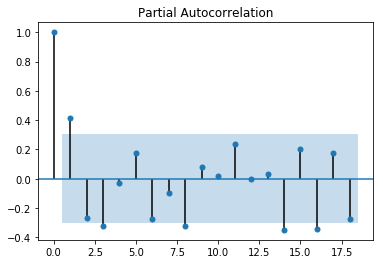

In [22]:
plot_pacf(train.mean_ovi, lags=18)

In [128]:
model = ARIMA(train.mean_ovi, order=(12,0,0))
fit = model.fit()
pred = fit.predict(start = train.index[-1]+pd.DateOffset(months=1), end = test.index[-1])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [129]:
train['pred'] = train.mean_ovi
empty['pred'] = pred[0]
test['pred']=pred[1:]
final_df = pd.concat([train, empty, test]).sort_index()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52]), <a list of 53 Text xticklabel objects>)

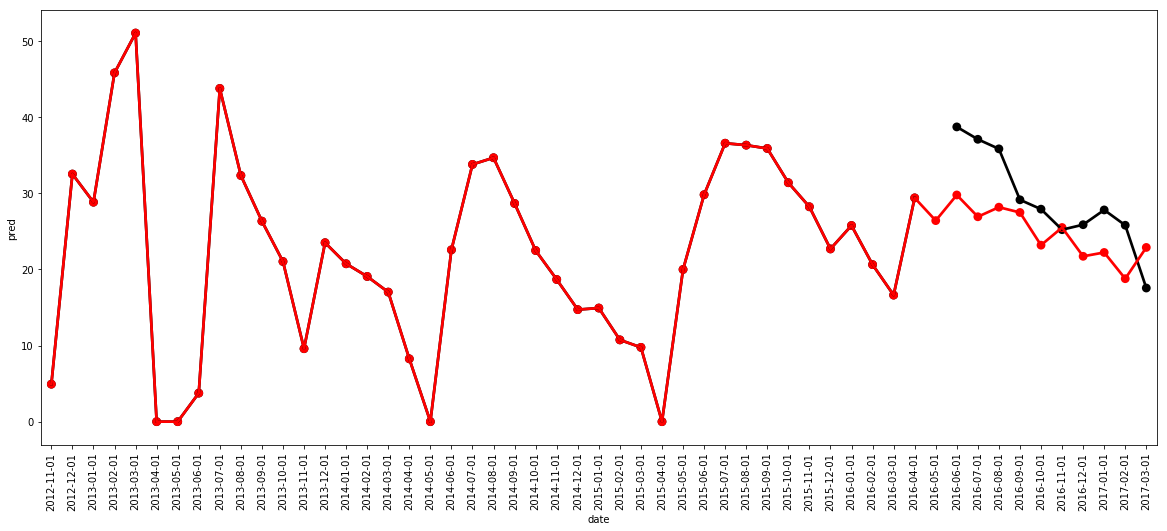

In [130]:
sns.set_context({"figure.figsize": (20, 8)})
sns.pointplot(x = final_df.index, y=final_df.mean_ovi, color='black')
sns.pointplot(x=final_df.index, y=final_df.pred, color='red')
plt.xticks(rotation=90)

In [131]:
mean_squared_error(test.pred, test.mean_ovi)

39.39716631981224

In [133]:
compute_mape(test.pred, test.mean_ovi)

18.941128963586674

# SARIMA model

In [75]:
train['year_lagged_mean_ovi'] = train.mean_ovi.shift(12)
train['year_diff_mean_ovi'] = train.mean_ovi- train.year_lagged_mean_ovi

In [80]:
yoy_ts = train.loc[~train.year_diff_mean_ovi.isnull()].year_diff_mean_ovi

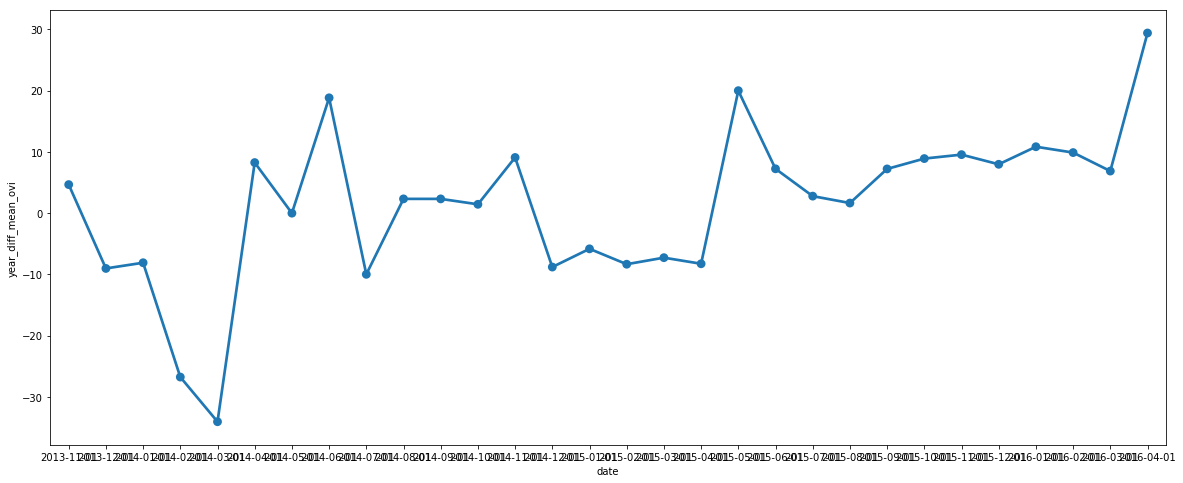

In [85]:
sns.pointplot(x = yoy_ts.index, y=yoy_ts)

# This looks pretty much like a random walk

(array([ 1.,  1.,  0.,  3.,  5.,  6., 10.,  1.,  2.,  1.]),
 array([-34.04333333, -27.698     , -21.35266667, -15.00733333,
         -8.662     ,  -2.31666667,   4.02866667,  10.374     ,
         16.71933333,  23.06466667,  29.41      ]),
 <a list of 10 Patch objects>)

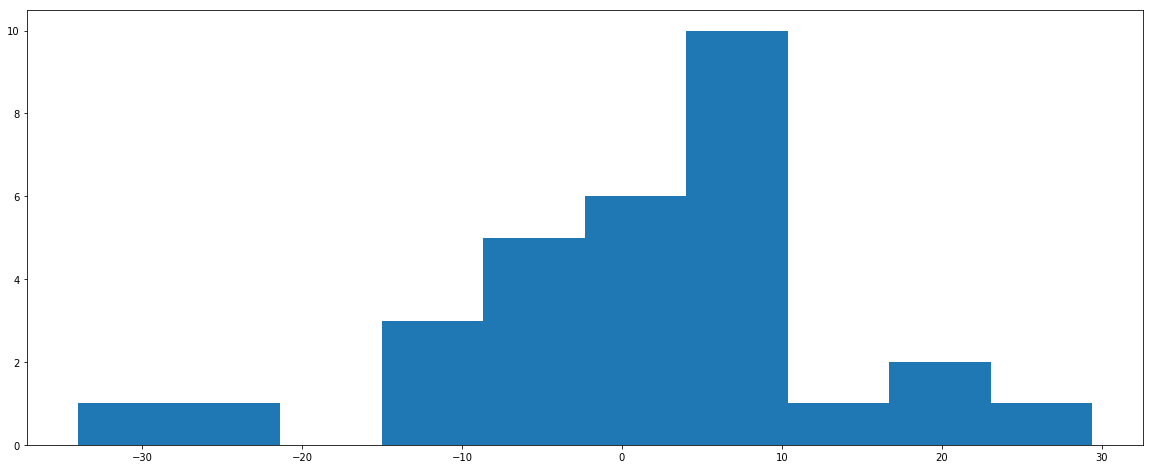

In [92]:
plt.hist(yoy_ts)

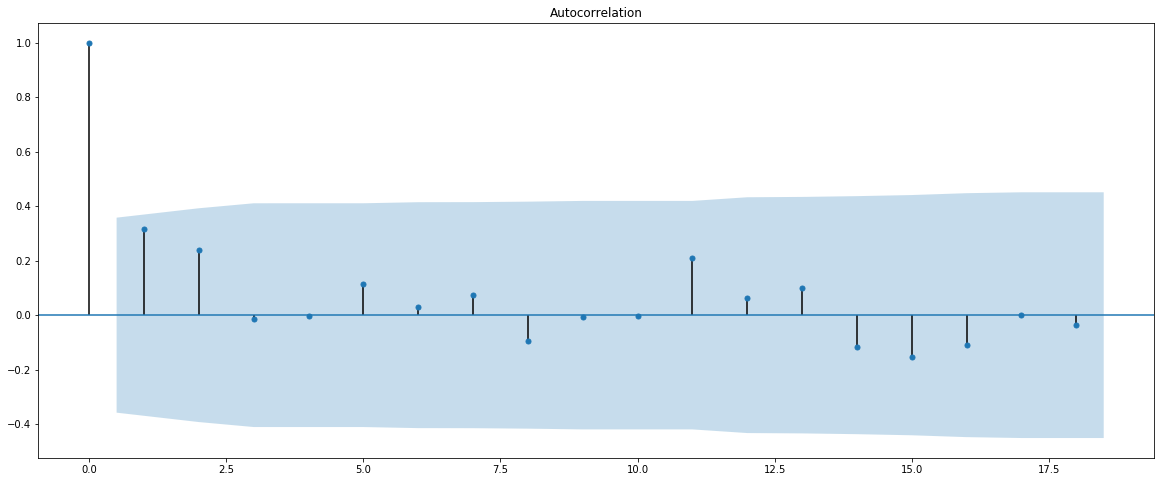

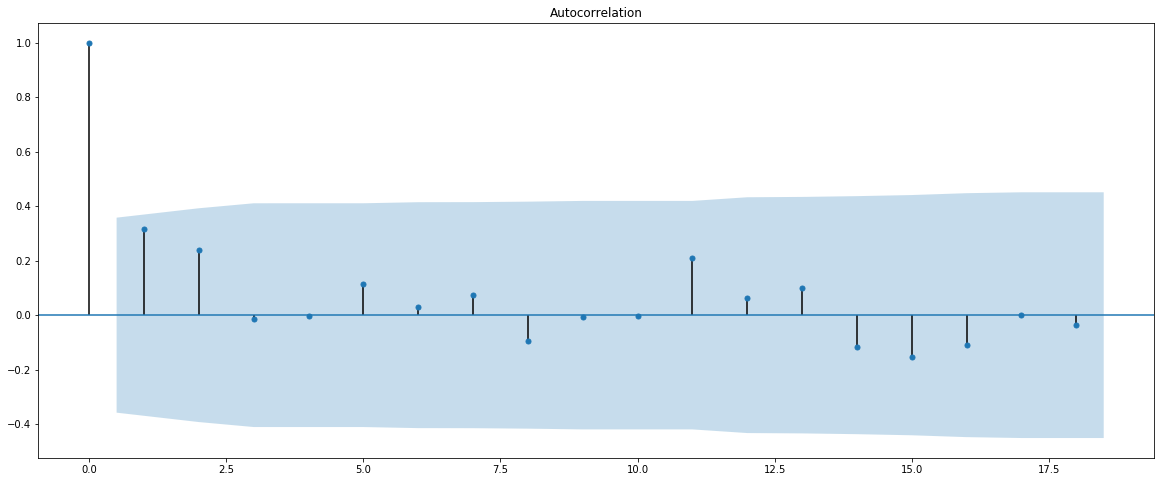

In [86]:
plot_acf(yoy_ts, lags=18)

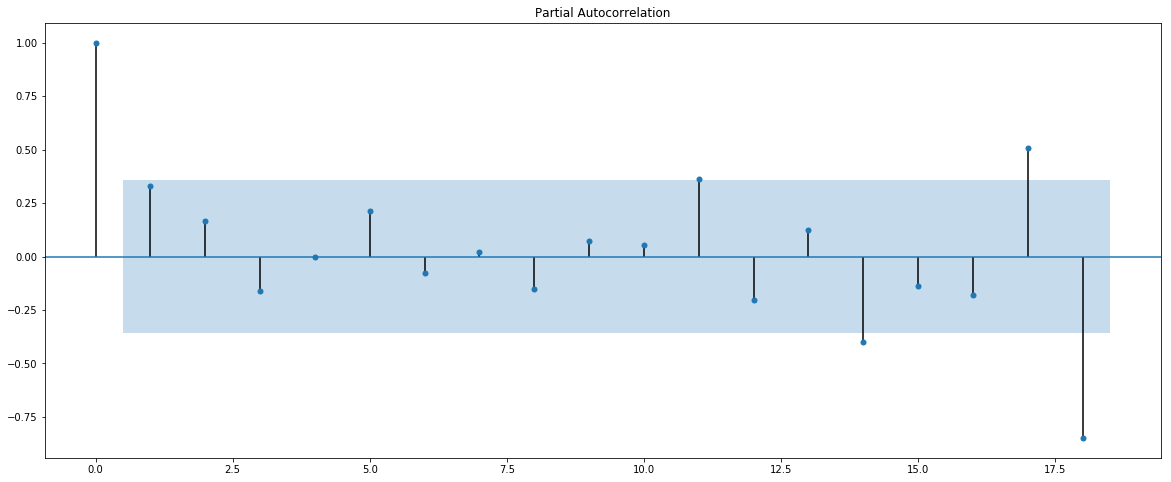

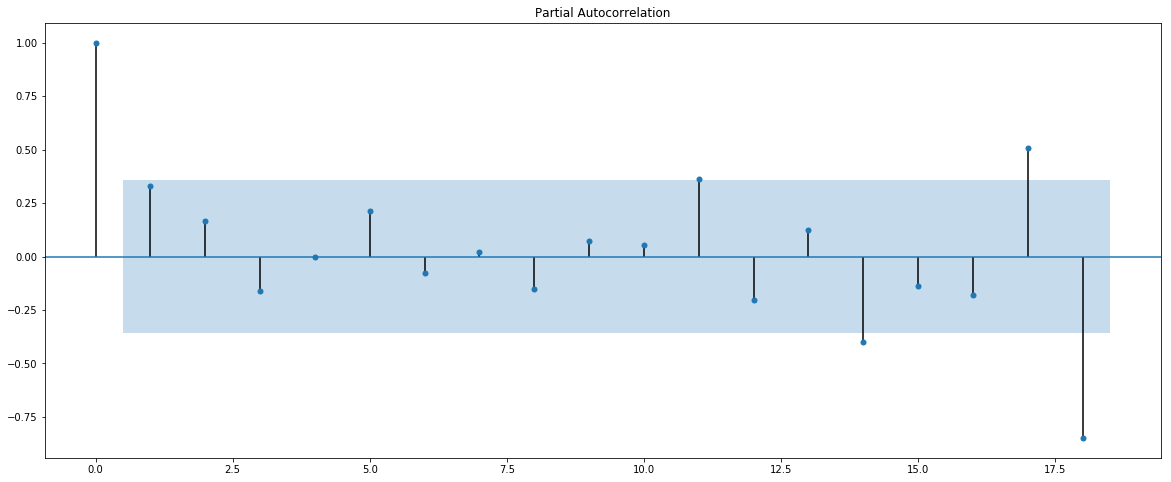

In [109]:
plot_pacf(yoy_ts, lags=18)

In [102]:
sarima_model = SARIMAX(train.mean_ovi, order=(12,0,0), seasonal_order=(0,0,0,12))
sarima_fit = sarima_model.fit()
pred = sarima_fit.predict(start = train.index[-1]+pd.DateOffset(months=1), end = test.index[-1])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [88]:
train['pred'] = train.mean_ovi
empty['pred'] = pred[0]
test['pred']=pred[1:]
final_df = pd.concat([train, empty, test]).sort_index()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52]), <a list of 53 Text xticklabel objects>)

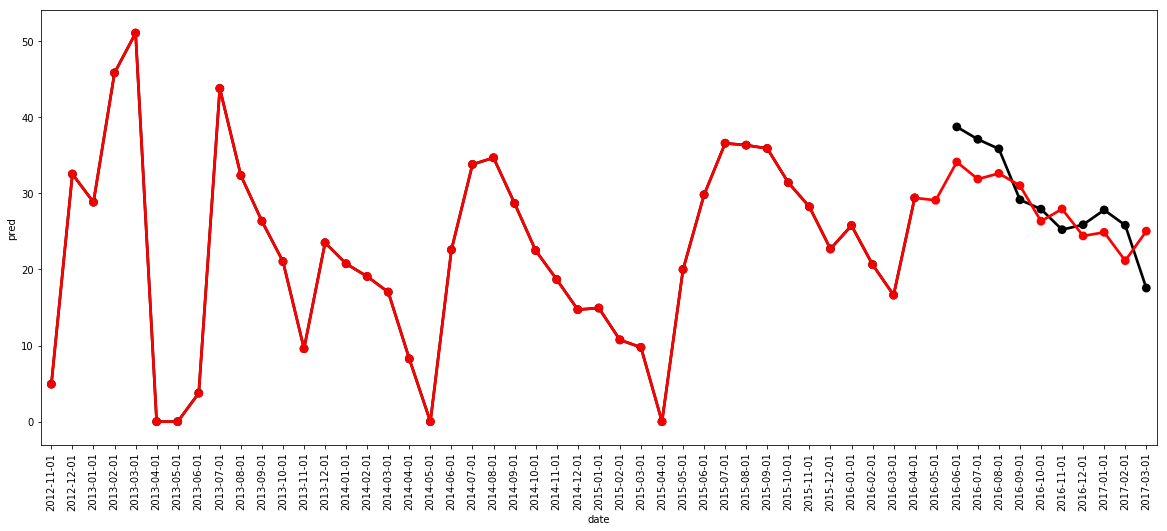

In [108]:
sns.set_context({"figure.figsize": (20, 8)})
sns.pointplot(x = final_df.index, y=final_df.mean_ovi, color='black')
sns.pointplot(x=final_df.index, y=final_df.pred, color='red')
plt.xticks(rotation=90)

In [93]:
np.sqrt(mean_squared_error(test.pred, test.mean_ovi))

4.00981752342278

In [94]:
res = test.mean_ovi - test.pred 

In [100]:
res.mean()

1.1659793229102817

In [101]:
res.median()

2.2624208530576393

(array([1., 0., 0., 1., 1., 0., 0., 2., 2., 3.]),
 array([-7.47727939, -6.20665281, -4.93602622, -3.66539963, -2.39477305,
        -1.12414646,  0.14648013,  1.41710671,  2.6877333 ,  3.95835989,
         5.22898647]),
 <a list of 10 Patch objects>)

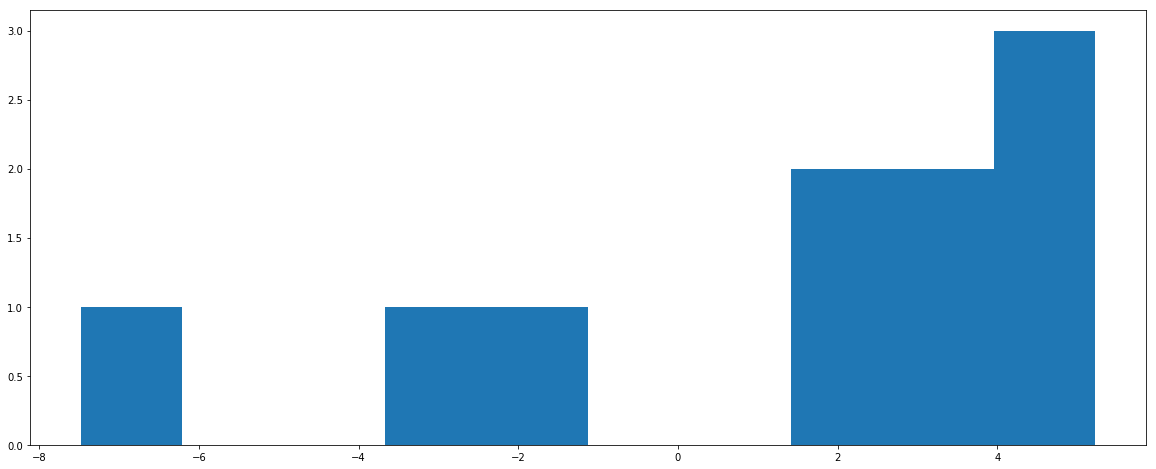

In [97]:
plt.hist(x=res)

# Gridsearch over SARIMAX

In [185]:
# Setting search space for p,d,q components
arima_range = {'p':[0,1,11,12], 'd':[0], 'q':[0,1,12]}

# Setting parameters for seasonal components
season_range = {'s_p':[0], 's_d':[0], 's_q':[0], 'S':[6,12]}

In [190]:
def grid_search_sarima(arima_range:dict, season_range:dict, train, test):
    performance=pd.DataFrame(columns=['arima_coeffs', 'season_coeffs', 'rmse', 'mape'])
    for p in arima_range['p']:
        for d in arima_range['d']:
            for q in arima_range['q']:
                for s_p in season_range['s_p']:
                    for s_d in season_range['s_d']:
                        for s_q in season_range['s_q']:
                            for S in season_range['S']:
                                arima_params = (p,d,q)
                                season_params = (s_p, s_d, s_q, S)
                                try:
                                    print(arima_params, season_params)
                                    pred = fit_predict(train.mean_ovi, arima_params, season_params, train.index[-1]+pd.DateOffset(months=1), test.index[-1])
                                    mape = compute_mape(pred[1:], test.mean_ovi)
                                    temp = pd.DataFrame(columns=['arima_coeffs', 'season_coeffs', 'rmse', 'mape'],
                                                        data ={'arima_coeffs':[arima_params],
                                                               'season_coeffs':[season_params], 
                                                               'rmse':[np.sqrt(mean_squared_error(pred[1:], test.mean_ovi))], 
                                                               'mape':[mape]})
                                    performance = pd.concat([performance, temp], ignore_index=True)
                                except ValueError:
                                    pass
                                except np.linalg.LinAlgError:
                                    pass
    return performance

In [191]:
def fit_predict(train_set, arima_params:tuple, season_params:tuple, start_date, end_date):
    model = SARIMAX(train_set, order=arima_params, seasonal_order=season_params)
    fitted = model.fit()
    pred = fitted.predict(start = start_date, end = end_date)
    return pred

In [192]:
def compute_mape(pred, actuals):
    return np.mean(np.abs((actuals - pred) / actuals)) * 100

In [193]:
res_df = grid_search_sarima(arima_range, season_range, train, test)

(0, 0, 0) (0, 0, 0, 6)
(0, 0, 0) (0, 0, 0, 12)
(0, 0, 1) (0, 0, 0, 6)
(0, 0, 1) (0, 0, 0, 12)
(0, 0, 12) (0, 0, 0, 6)
(0, 0, 12) (0, 0, 0, 12)
(1, 0, 0) (0, 0, 0, 6)
(1, 0, 0) (0, 0, 0, 12)
(1, 0, 1) (0, 0, 0, 6)
(1, 0, 1) (0, 0, 0, 12)
(1, 0, 12) (0, 0, 0, 6)
(1, 0, 12) (0, 0, 0, 12)
(11, 0, 0) (0, 0, 0, 6)
(11, 0, 0) (0, 0, 0, 12)
(11, 0, 1) (0, 0, 0, 6)
(11, 0, 1) (0, 0, 0, 12)
(11, 0, 12) (0, 0, 0, 6)
(11, 0, 12) (0, 0, 0, 12)
(12, 0, 0) (0, 0, 0, 6)
(12, 0, 0) (0, 0, 0, 12)
(12, 0, 1) (0, 0, 0, 6)
(12, 0, 1) (0, 0, 0, 12)
(12, 0, 12) (0, 0, 0, 6)
(12, 0, 12) (0, 0, 0, 12)


In [195]:
res_df.sort_values('rmse')

,arima_coeffs,season_coeffs,rmse,mape
12,"(12, 0, 0)","(0, 0, 0, 6)",4.009818,13.471283
13,"(12, 0, 0)","(0, 0, 0, 12)",4.009818,13.471283
10,"(11, 0, 1)","(0, 0, 0, 6)",4.035014,13.490571
11,"(11, 0, 1)","(0, 0, 0, 12)",4.035014,13.490571
8,"(11, 0, 0)","(0, 0, 0, 6)",4.040198,13.472194
9,"(11, 0, 0)","(0, 0, 0, 12)",4.040198,13.472194
14,"(12, 0, 1)","(0, 0, 0, 6)",4.270287,13.683650
15,"(12, 0, 1)","(0, 0, 0, 12)",4.270287,13.683650
4,"(1, 0, 0)","(0, 0, 0, 6)",17.736296,62.002456
5,"(1, 0, 0)","(0, 0, 0, 12)",17.736296,62.002456
